In [1]:
%load_ext autoreload
%autoreload 2

# Stations Visualized on the Map

In [2]:
from folium import Map, Popup
from folium.map import Marker
from folium.plugins import HeatMap
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist

## Data

### Particle Concentrations

In [3]:
concentrations = pd.read_csv('data/beijing_17_18_aq.csv')
concentrations['datetime'] = pd.to_datetime(concentrations['utc_time'])
concentrations = concentrations.rename(columns={'stationId': 'station'}).drop('utc_time', axis=1)
concentrations['station_type'] = concentrations['station'].apply(lambda s: s[s.find('_')+1:])
concentrations['station'] = concentrations['station'].apply(lambda s: s[:s.find('_')])
concentrations.set_index(['station', 'datetime'], inplace=True)
dupes = concentrations[concentrations.index.duplicated()]
print('Index duplicates: {}'.format(dupes.shape[0]))
concentrations.drop(dupes.index, inplace=True)
concentrations.sample(3)

Index duplicates: 6475


,,PM2.5,PM10,NO2,CO,O3,SO2,station_type
station,datetime,,,,,,,
dongsihuan,2017-02-09 19:00:00,6.0,22.0,11.0,0.3,63.0,4.0,aq
aotizhongxin,2017-04-24 07:00:00,56.0,NaN,9.0,0.1,116.0,2.0,aq
wanliu,2017-08-27 02:00:00,8.0,28.0,38.0,0.5,44.0,3.0,aq


### Weather

In [4]:
weather = pd.read_csv('data/beijing_17_18_meo.csv')
weather['datetime'] = pd.to_datetime(weather['utc_time'])
weather = weather.rename(columns={'station_id': 'station'}).drop('utc_time', axis=1)
weather['station_type'] = weather['station'].apply(lambda s: s[s.find('_')+1:])
weather['station'] = weather['station'].apply(lambda s: s[:s.find('_')])
weather.set_index(['station', 'datetime'], inplace=True)
weather.sample(3)

,,longitude,latitude,temperature,pressure,humidity,wind_direction,wind_speed,weather,station_type
station,datetime,,,,,,,,,
mentougou,2017-02-08 13:00:00,116.156389,39.887778,-2.0,1022.2,23,319.0,8.6,Sunny/clear,meo
hadian,2017-08-02 13:00:00,116.290556,39.986944,25.2,995.4,94,18.0,1.1,Fog,meo
shunyi,2017-12-01 06:00:00,116.615278,40.126667,4.9,1024.8,23,185.0,2.8,Sunny/clear,meo


### Stations

In [5]:
stations = pd.read_csv('data/Beijing_AirQuality_Stations_en.csv', sep=';')
stations = stations.rename(columns={'Station ID': 'station', 'Type': 'location_type'})
stations['latitude'] = stations['latitude'].apply(lambda l: float(l.replace(',', '.')))
stations['longitude'] = stations['longitude'].apply(lambda l: float(l.replace(',', '.')))
stations['station_type'] = stations['station'].apply(lambda s: s[s.find('_')+1:])
stations['station'] = stations['station'].apply(lambda s: s[:s.find('_')])
stations.set_index('station', inplace=True)
print(stations.shape)
stations.head()

(35, 4)


,longitude,latitude,location_type,station_type
station,,,,
dongsi,116.417,39.929,urban,aq
tiantan,116.407,39.886,urban,aq
guanyuan,116.339,39.929,urban,aq
wanshouxigong,116.352,39.878,urban,aq
aotizhongxin,116.397,39.982,urban,aq


## Maps 

In [6]:
from src.maps import map_points, distance_on_sphere_numpy, plot_dist_stations

### Airquality Stations

In [7]:
map_points(stations.reset_index(), plot_points=True, zoom_start=9)

We can group the stations by their location type and plot them all together.

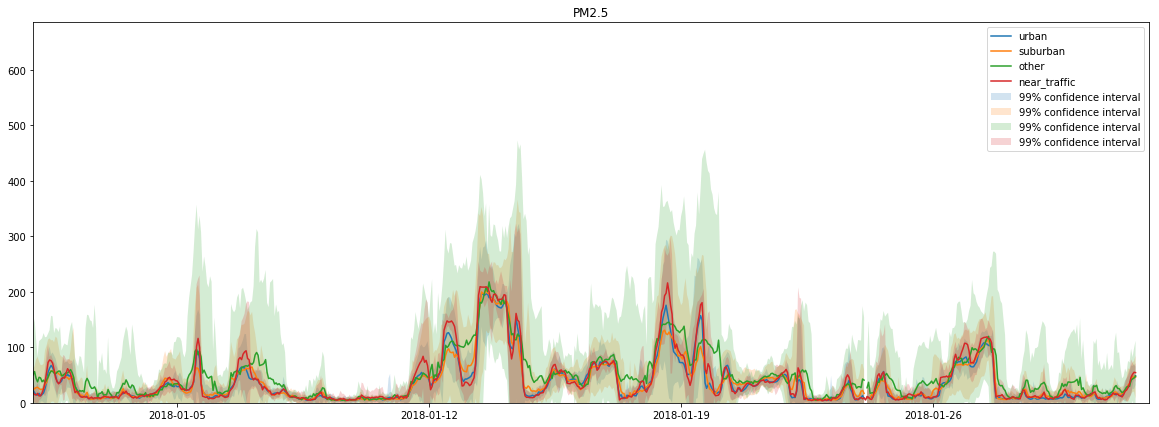

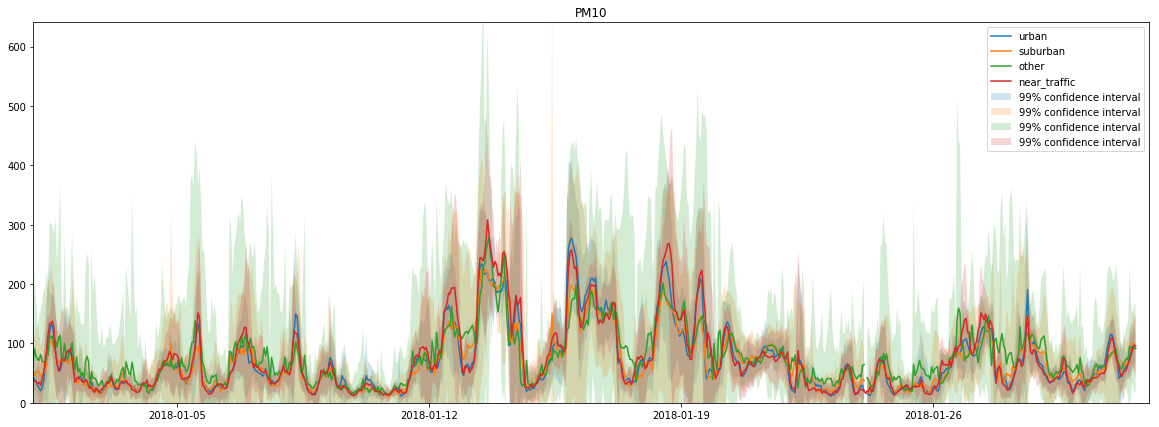

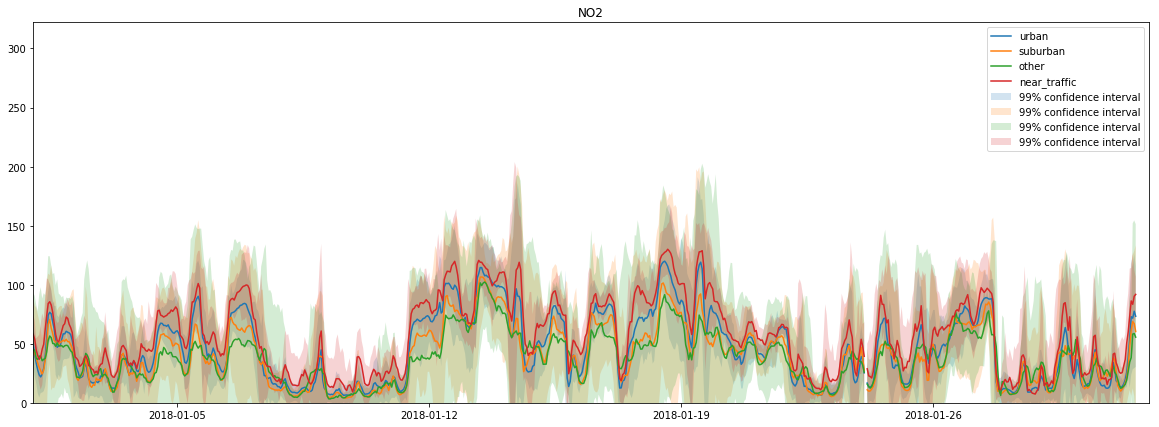

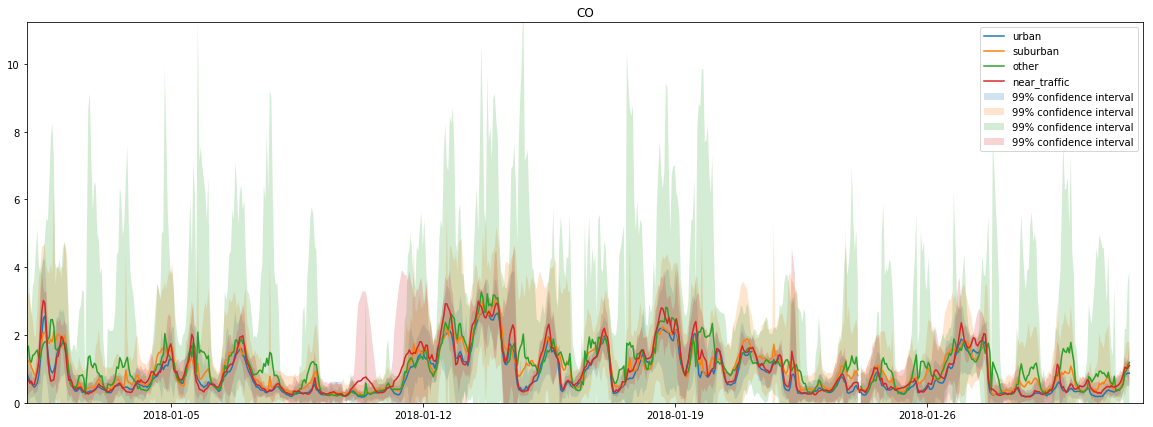

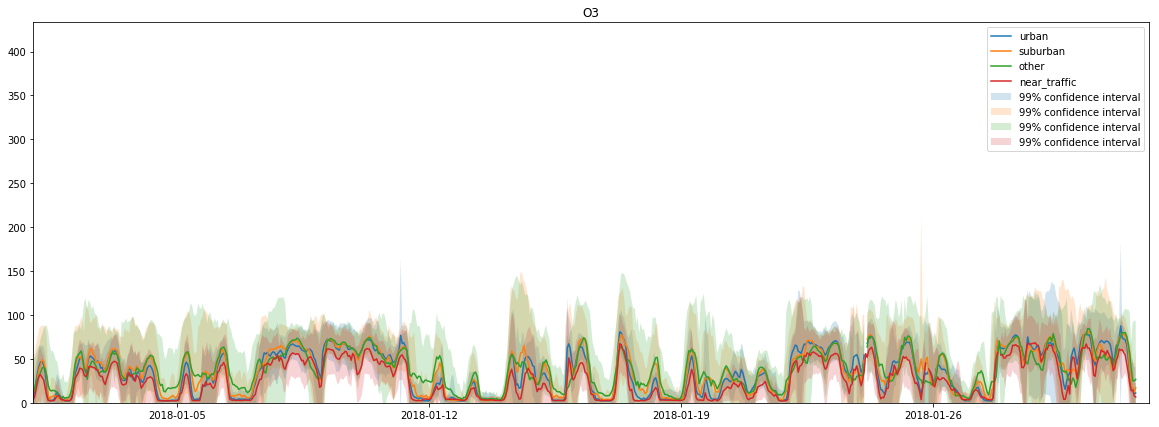

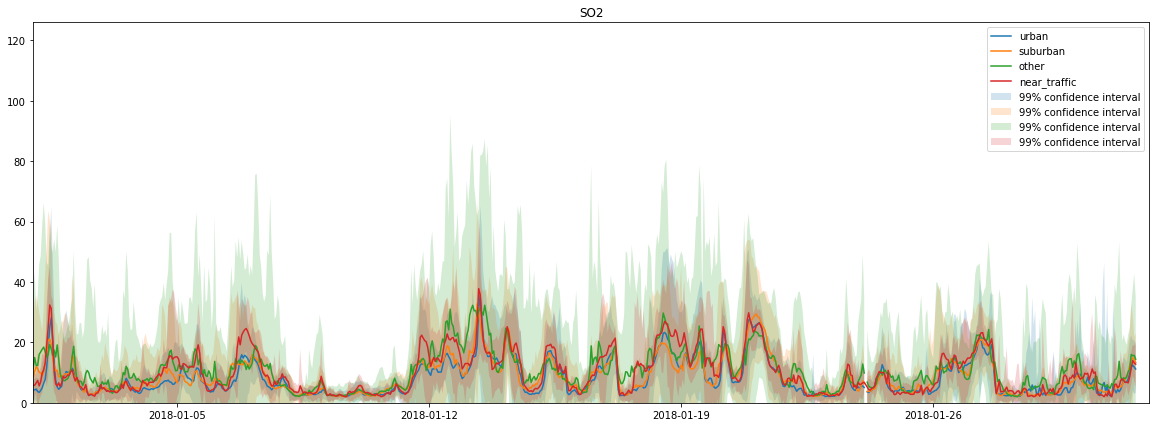

In [8]:
from numpy import percentile


for particle in concentrations.columns.tolist()[:-1]:
    plt.figure(figsize=(20, 7))
    for location_type in stations.location_type.unique():
        group_stations = stations[stations.location_type == location_type].index.tolist()
        group_summary = concentrations.loc[group_stations, particle].groupby('datetime').agg(['std', 'mean'])
        plt.plot(group_summary['mean'], label=location_type)
        plt.fill_between(group_summary['mean'].index,
                         group_summary['mean'] - 2.575 * group_summary['std'],
                         group_summary['mean'] + 2.575 * group_summary['std'],
                 alpha=.2, label='99% confidence interval')
        y_perc = 99.
        plt.ylim([0, percentile((group_summary['std'] + group_summary['mean'] * 1.96).fillna(0), y_perc)])
        plt.xlim(['2018-01', '2018-02'])
        plt.legend()
        plt.title(particle)
    plt.show()

### Weather Stations

In [9]:
map_points(weather.groupby('station').mean().reset_index(), plot_points=True, zoom_start=9)